In [1]:
import numpy as np
import pyemma
import matplotlib.pyplot as plt
import pyemma.plots as mplt
import h5py
from MSMRD.trajectories import allTrajs
%matplotlib inline

In [2]:
# Create a child class from the main class in trajectories_class.py
class asym2Dtraj(allTrajs):
    def __init__(self, centers=None, Trajs=None):
        super(asym2Dtraj, self).__init__(Trajs)
        if centers == None:
            centers = []
        self.centers = centers
        self.innerMSMrad = 2.0
        self.entryRad = 2.6
        self.bathRad = 3.0
        self.bathRadOut = 4.0
        self.angularPartitions = 15
        self.Ncenters = len(self.centers)
    
    # Overwrite getState function in parent class
    #discretize trajectory: use two additional rings of states for entry and exit states
    #cluster volume should be on the same order of magnitute as for the internal states
    def getState(self, coord, prevst):
        radius = np.linalg.norm(coord)
        # inner MSM
        if radius < self.innerMSMrad:
            cen2coord = self.centers - coord
            norm = np.linalg.norm(cen2coord, axis = 1)
            index = np.argmin(norm)
            if (norm[index] <= 0.2 ):
                return index
            # if no new state found, return previous state
            return prevst
        # Entry states 
        elif radius < self.entryRad:
            theta = np.arctan2(coord[0], coord[1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
            angularState = int(theta/(2*np.pi)*self.angularPartitions)
            assert(angularState < self.angularPartitions)
            return self.Ncenters + angularState
        # Exit states 
        elif radius < self.bathRad:
            theta = np.arctan2(coord[0], coord[1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
            angularState = int(theta/(2*np.pi)*self.angularPartitions)
            assert(angularState < self.angularPartitions)
            return self.Ncenters + self.angularPartitions + angularState
        # Bath state
        elif radius < self.bathRadOut:
            theta = np.arctan2(coord[0], coord[1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
            angularState = int(theta/(2*np.pi)*self.angularPartitions)
            assert(angularState < self.angularPartitions)
            return self.Ncenters + 2*self.angularPartitions + angularState
    
        
    # Overwrite getMilestones function
    def getMilestones(self):
        int_th = 2*np.pi/self.angularPartitions
        # inner MSM
        for i in range(self.Ncenters):
            self.milestones[i] = self.centers[i]
        # entry states
        for i in range(self.angularPartitions):
            j = i + self.Ncenters;
            r = 0.5*(self.innerMSMrad + self.entryRad)
            th = i*int_th + 0.5*int_th
            self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
        # exit states
        for i in range(self.angularPartitions):
            j = i + self.Ncenters + self.angularPartitions;
            r = 0.5*(self.entryRad + self.bathRad)
            th = i*int_th + 0.5*int_th
            self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
                # entry states
        for i in range(self.angularPartitions):
            j = i + self.Ncenters + 2*self.angularPartitions;
            r = 0.5*(self.bathRad + self.bathRadOut)
            th = i*int_th + 0.5*int_th
            self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
        
    
    # Overwrite getRegionMap function
    def getRegionMap(self):
        for i in range(self.Ncenters):
            statename = 'Inner state ' + str(i)
            self.regionMap[i] = statename
        for i in range(self.angularPartitions):
            statename = 'Entry state ' + str(i)
            j = self.Ncenters + i
            self.regionMap[j] = statename
        for i in range(self.angularPartitions):
            statename = 'Exit state ' + str(i)
            j = self.Ncenters + self.angularPartitions + i
            self.regionMap[j] = statename
        for i in range(self.angularPartitions):
            statename = 'Bath state ' + str(i)
            j = self.Ncenters + 2*self.angularPartitions + i
            self.regionMap[j] = statename


In [3]:
numfiles = 12
# Extract trajectories from file using asym2Dtraj class
fname = '../data/asym2D/2DasymTrajsLong_bigR_bigT_'
minima = [[0.0,0.0], [1.0,0.0] , [1.1, 1.0], [-0.1,0.9], [-1.3,0.8], \
                       [-1.0,-0.2], [-0.6,-1.0], [0.9,-0.8], [0.2,-1.5]]
alltrajs = asym2Dtraj(minima, []) # define allTrajs object
#alltrajs = allTrajs_inner([])
dimension = 2
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    traj = data[:,1:dimension+1]
    alltrajs.Trajs.append(traj)

In [4]:
# Calculate discrete trajectories and make sure it is clean (no "None" elements)
dtrajs = alltrajs.getdTrajsclean()
# Obtain centers of each state and save
centersdict = alltrajs.getMilestones()
centers = alltrajs.getMilestonesArray()

In [5]:
# Obtained implied time scales using pyemma
its = pyemma.msm.its(dtrajs, lags = 3000)

estimating MaximumLikelihoodMSM: 100% (19/19) [####################] eta 00:00 |

(array([  1.00000000e+01,   1.00000000e+02,   1.00000000e+03,
          1.00000000e+04,   1.00000000e+05]),
 <a list of 5 Text yticklabel objects>)

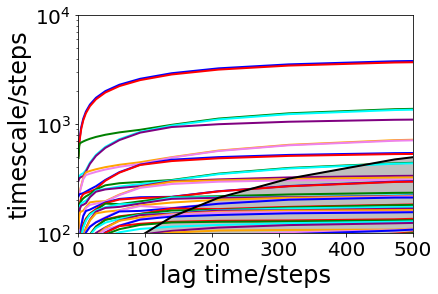

In [6]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=True, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(-100,1700)
plt.xlim(0,500)
plt.ylim(100,10000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

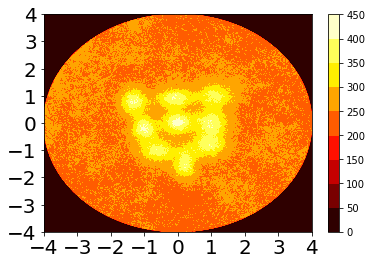

In [7]:
MSMradius = 4.0
X = np.arange(-MSMradius, MSMradius, 0.01)
Y = np.arange(-MSMradius, MSMradius, 0.01)
Zfull = np.zeros([X.shape[0]-1, X.shape[0]-1])
for traj in alltrajs.Trajs:
    hist = np.histogram2d(traj[:,1], traj[:,0], bins = [X, Y], normed=False)
    Zfull += hist[0]
extent = [X[0], X[-1], Y[0], Y[-1]]
cp = plt.contourf(Zfull, 10, cmap=plt.cm.hot, extent=extent)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.colorbar()

In [13]:
# Choose lag time and obtain MSM "M" for our milestones
msm_lag = 50
M = pyemma.msm.estimate_markov_model(dtrajs, msm_lag, reversible=True)

In [14]:
milestoningCKtest = M.cktest(4)

estimating MaximumLikelihoodMSM: 100% (9/9) [######################] eta 00:00 -

(<matplotlib.figure.Figure at 0x7f58fed10350>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f58ef9d6d50>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f58ef1fc710>]], dtype=object))

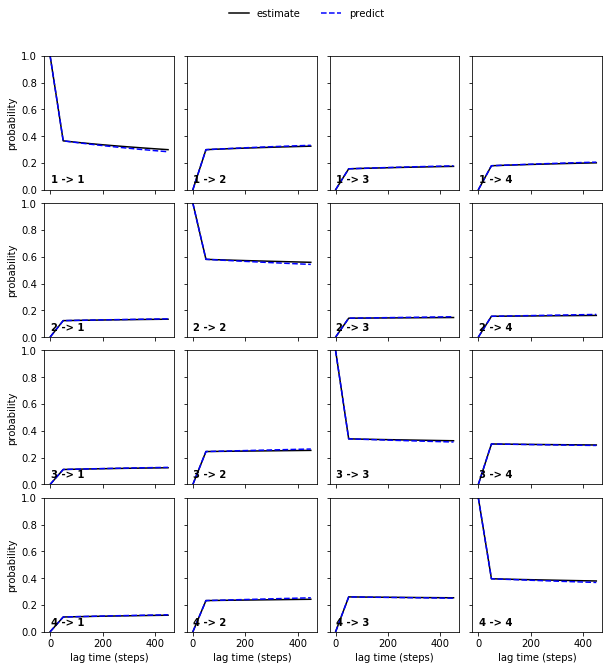

In [15]:
mplt.plot_cktest(milestoningCKtest)

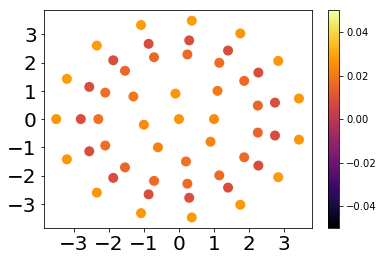

In [9]:
# Plot states and color them according to their weight in a given eigenmode
eigenmode = 0 # 0 = stationary distribution
vectors = M.eigenvectors_left()
value = M.eigenvalues()
#print M.timescales()[:10] 
#print -msm_lag/np.log(value[1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sc = plt.scatter(centers[:,0], centers[:,1], c=vectors[eigenmode][:], cmap=plt.cm.inferno, linewidths = 0, s=100)
plt.colorbar()
plt.clim(-0.05,0.05)

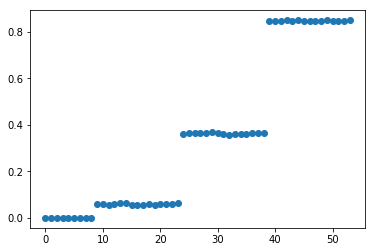

In [11]:
# Plot transition probabilities to bath state
T = M.transition_matrix
plt.plot(np.sum(T[:,-15:],axis=1), 'o')

In [19]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class MSMmodel(object):    
    def __init__(self, tmatrix, centers, parameters):
        self.tmatrix = tmatrix
        self.centers= centers
        self.parameters = parameters
parameters = {}
parameters['interactionRadius'] = alltrajs.innerMSMrad
parameters['entryRadius'] = alltrajs.entryRad
parameters['bathRadius'] = alltrajs.bathRad
parameters['outerBathRadius'] = alltrajs.bathRadOut
parameters['NCenters'] = alltrajs.Ncenters
parameters['NangularPartitions'] = alltrajs.angularPartitions
parameters['lagtime'] = 100
model = MSMmodel(T, minima, parameters)

In [20]:
import pickle
pickle.dump(model, open('../data/asym2D_lag100.p', 'wb'))

In [16]:
T.shape

(54, 54)